# **Telecom Churn Lifetime Modeling with Survival Analysis & Retention Insights**                                                                      
**What is churn?**

It implies that when a customer stops consuming the particular product/serviced provided by the company, within a given time period. It could be months, a quarter, as well as annual.

&nbsp;

**1. Problem Statement?**

The telecommunication firm will suffer losses if the customer discontinues the use of the service (churn). In fact, most models only specify who is going to churn, not when or how long these people churn. The project applies survival analysis techniques to predict when customers will remain and provide relevant retention insights.

&nbsp;

**2. Dataset Overview?**

 In this project, we have used dataset from Kaggle,that is posted by `BlastChar`. This dataset is a CSV file,which contains 7,043 customers and 21 features.Features include demographics, tenure, billing, services used, and contract/payment details.

&nbsp;

**3. What Value This Project Provides?**
- **More than prediction :** Instead of only pointing out which customers will churn.This project conducts a survival analysis with results that not only indicate which customers will churn but when they will churn and takes into consideration the customers who have not churned yet.
- **Business-useful insights :**  The findings can be applied to inform the prioritization of retention offers, minimize customer attrition, and maximize customer lifetime value, which all represent direct gains to the bottom line.




In [153]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Installing Libraries**

In [154]:
!pip install lifelines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split

# **Data Loading**

In [155]:
df = pd.read_csv("/Telco-Customer-Churn.csv")
print(df.head())                                     # Look at the first few rows to understand the features
print(df.info())                                     # Check data types

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

# **Data Cleaning**

In survival analysis, the Target is two columns:

1.Time (tenure):  How long they stayed.

2.Event (Churn): Did they leave (1) or are they still here (0)?

In [156]:
df.drop("customerID", axis=1, inplace=True)                                                          # Drop ID because it's unique to every person and provides no pattern

In [157]:
# 1. Convert to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# 2. FIX: Instead of fillna(..., inplace=True), we re-assign the column
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# 3. Create the 'Event' column (using .map is faster than .apply)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 4. Fix tenure (0 to 0.5)
df['tenure'] = df['tenure'].replace(0, 0.5)

# **Building the Kaplan-Meier Curve**
Creating a global curve and then break it down by segments.

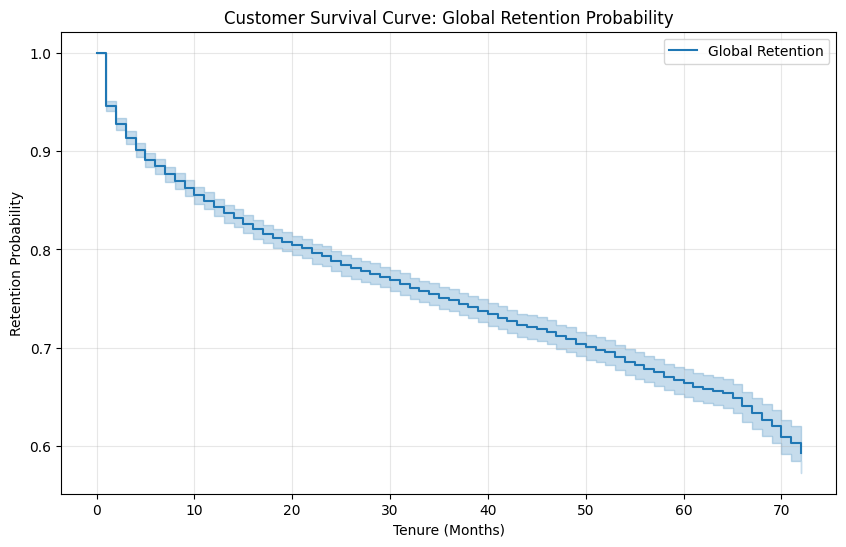

In [158]:
# 1. Initialize the Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# 2. Fit the data: Time is 'tenure', Event is 'Churn'
kmf.fit(durations=df['tenure'], event_observed=df['Churn'], label='Global Retention')

# 3. Plot the Survival Function
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title("Customer Survival Curve: Global Retention Probability")
plt.xlabel("Tenure (Months)")
plt.ylabel("Retention Probability")
plt.grid(True, alpha=0.3)
plt.show()

Look at where the line crosses the 0.5 (50%) mark on the Y-axis. That is the "Median Lifetime" of your customer base.

# **Segment Analysis**
The problem statement mentioned providing "relevant retention insights." So,we are comparing different groups, The Internet Service types.

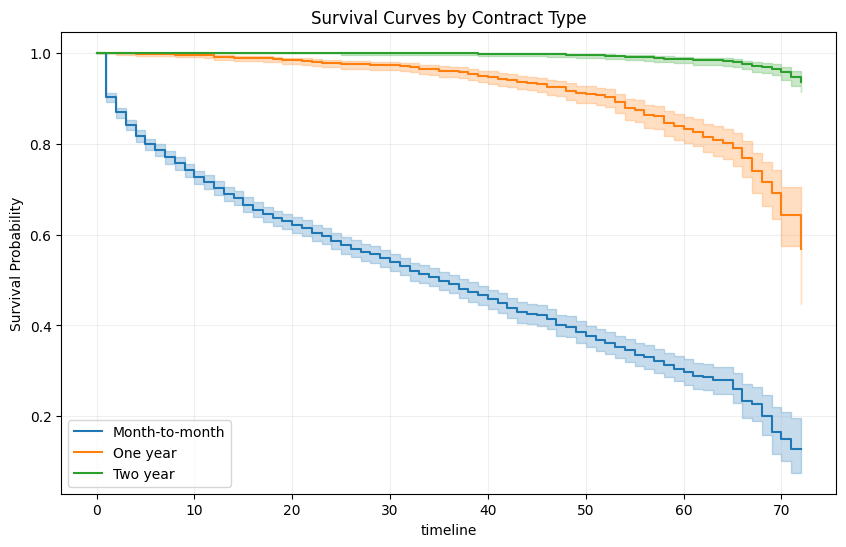

In [159]:
plt.figure(figsize=(10, 6))
for contract_type in df['Contract'].unique():
    mask = (df['Contract'] == contract_type)
    kmf.fit(df['tenure'][mask], df['Churn'][mask], label=contract_type)
    kmf.plot_survival_function()

plt.title('Survival Curves by Contract Type')
plt.ylabel('Survival Probability')
plt.grid(True, alpha=0.2)
plt.show()

The Insight: Month-to-month customers drop off significantly faster and more consistently than those on long-term contracts. This suggests a lack of loyalty or high price sensitivity in flexible plans, whereas Two-year contracts act as a powerful "retention shield," maintaining nearly 100% survival for most of the timeline.

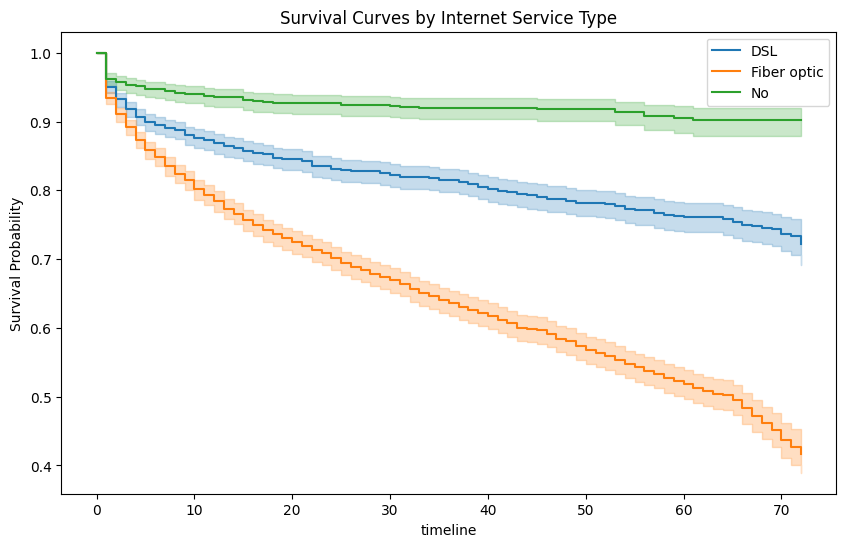

In [160]:
plt.figure(figsize=(10, 6))

# Identify unique internet services
services = df['InternetService'].unique()

for service in services:
    mask = (df['InternetService'] == service)
    # Fit KM for each specific group
    kmf.fit(df['tenure'][mask], df['Churn'][mask], label=service)
    kmf.plot_survival_function()

plt.title("Survival Curves by Internet Service Type")
plt.ylabel("Survival Probability")
plt.show()

The Insight: Fiber Optic customers drop off much faster than DSL customers. This is a huge finding, it suggests there might be a service quality issue or a pricing issue with Fiber.

# **Correlation Heatmap**
We use a heatmap to see if any features are perfectly correlated (1.0 or -1.0). If they are, one of them must be dropped to avoid the error.

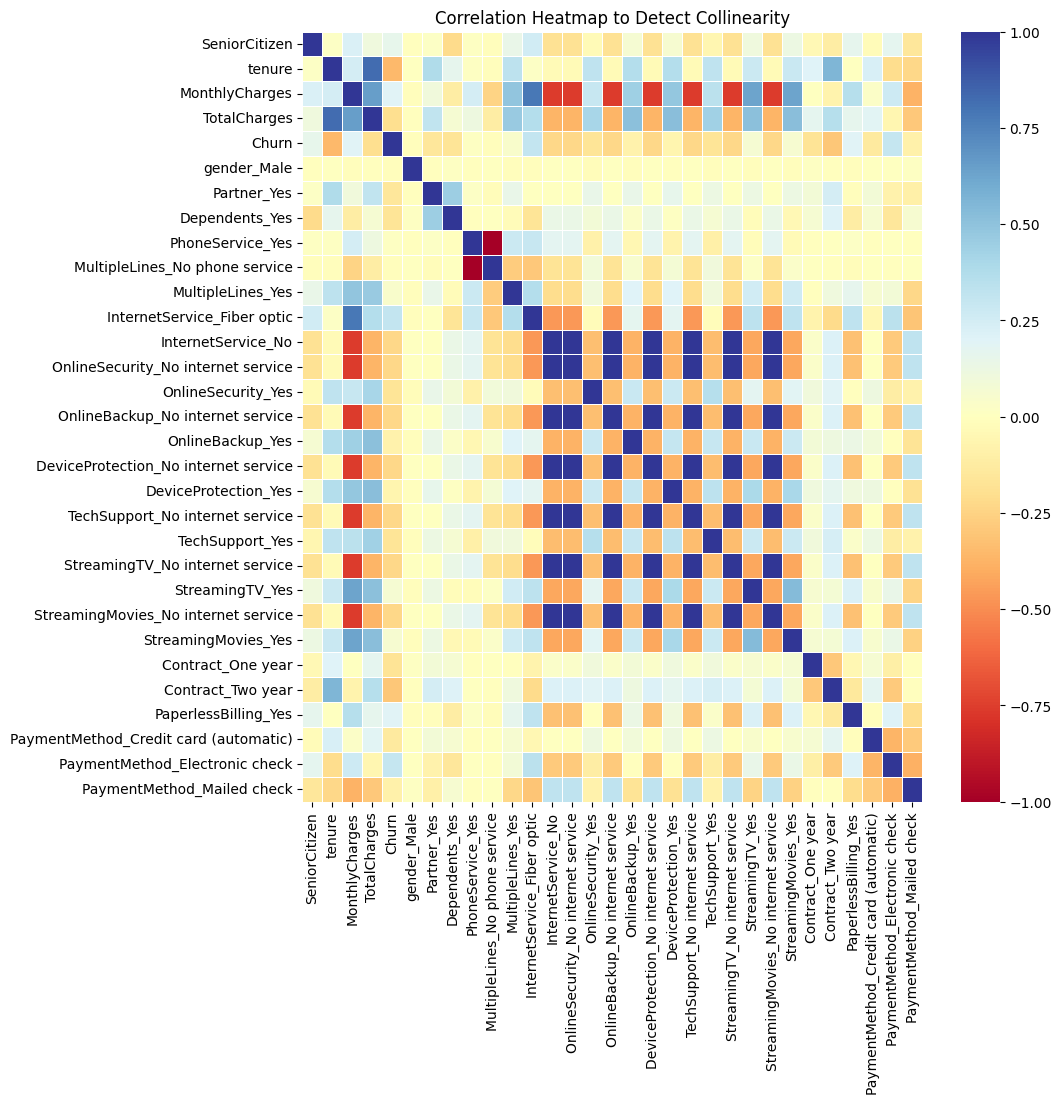

Correlation between TotalCharges and tenure: 0.8254860054782144


In [161]:
# --- STEP 3.5: COLLINEARITY CHECK ---

# 1. We need to encode the data briefly to check correlation of categories too
df_check = pd.get_dummies(df, drop_first=True)

# 2. Generate the correlation matrix
corr_matrix = df_check.corr()

# 3. Plot the Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='RdYlBu', linewidths=0.5)
plt.title("Correlation Heatmap to Detect Collinearity")
plt.show()

# 4. Identify high correlations (specifically TotalCharges vs MonthlyCharges/Tenure)
print("Correlation between TotalCharges and tenure:", df_check['TotalCharges'].corr(df_check['tenure']))

# **Data Encoding**
**Preparing for the Cox Model :**
The Cox Proportional Hazards (CPH) model is like a "Super Regression" for time. To run it, we must turn all text (Object) columns into numbers (0 and 1). This is called One-Hot Encoding.


In [162]:
# --- MISSING ENCODING STEP ---
# This converts categorical text (like 'Yes'/'No') into numbers the model can understand
df_encoded = pd.get_dummies(df, drop_first=True)

# Now, run your Step 7:
df_final = df_encoded.copy()

# Drop 'TotalCharges' as planned
if 'TotalCharges' in df_final.columns:
    df_final = df_final.drop(columns=['TotalCharges'])

print("Final feature set for Cox Model:", df_final.columns.tolist())

Final feature set for Cox Model: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [163]:
from sklearn.model_selection import train_test_split

# Split into 80% Training and 20% Testing
train_df, test_df = train_test_split(df_final, test_size=0.2, stratify=df_final['Churn'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 5634
Testing set size: 1409


Training the Cox Model
# **Training the Cox Model**
This model calculates the Hazard Ratio. If a variable has a ratio of 2.0, it means a customer with that trait is twice as likely to churn at any given moment compared to the baseline.

In [164]:
# --- STEP 8: MODEL TRAINING ---

# 1. Initialize the Cox model
# We add a 'penalizer' to provide stability to the coefficients
cph = CoxPHFitter(penalizer=0.1)

# 2. Fit the model to your cleaned data
# We tell it which column is the timeline (tenure) and which is the event (Churn)
cph.fit(df_final, duration_col='tenure', event_col='Churn')

# 3. Print the statistical summary
# This table is the "heart" of your research results
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -14339.18
         time fit was run = 2026-01-05 17:25:54 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                          0.01      1.01      0.05           -0.08            0.11                0.92                1.11
MonthlyCharges                        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
gender_Male                           -0.05      0.96      0.04           -0.12            0.03                0.88                1.03
Partner_Yes                           -0.41      0.66      0.04           -0.50           -0.33                0.61                0.72
Dependents_Yes                        -0.16      0.86      0.05           -0.26           -0.06                0.77                0.95
PhoneService_Yes                       0.03      1.03      0.10           -0.16            0.23                0.85                1.26
MultipleLines_No phone service        -0.03      0.97      0.10           -0.23            0.16                0.80                1.18
MultipleLines_Yes                     -0.32      0.73      0.04           -0.40           -0.23                0.67                0.79
InternetService_Fiber optic            0.32      1.38      0.05            0.22            0.43                1.24                1.53
InternetService_No                    -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
OnlineSecurity_No internet service    -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
OnlineSecurity_Yes                    -0.54      0.58      0.05           -0.64           -0.44                0.53                0.64
OnlineBackup_No internet service      -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
OnlineBackup_Yes                      -0.50      0.61      0.04           -0.58           -0.41                0.56                0.66
DeviceProtection_No internet service  -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
DeviceProtection_Yes                  -0.32      0.72      0.04           -0.41           -0.23                0.66                0.79
TechSupport_No internet service       -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
TechSupport_Yes                       -0.43      0.65      0.05           -0.53           -0.34                0.59                0.71
StreamingTV_No internet service       -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
StreamingTV_Yes                       -0.09      0.92      0.05           -0.18           -0.00                0.84                1.00
StreamingMovies_No internet service   -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
StreamingMovies_Yes                   -0.13      0.88      0.05           -0.22           -0.04                0.80                0.96
Contract_One year                     -0.82      0.44      0.06           -0.93           -0.71                0.39                0.49
Contract_Two year                     -1.18      0.31      0.06           -1.31           -1.06                0.27                0.35
PaperlessBilling_Yes               

In [165]:
# --- STEP 8.1: MODEL VALIDATION (C-INDEX) ---
from lifelines.utils import k_fold_cross_validation
import numpy as np

# Calculate the Concordance Index (C-index)
c_index = cph.concordance_index_
print(f"Model Concordance Index: {c_index:.3f}")

# Perform 5-fold cross-validation to ensure stability
cv_results = k_fold_cross_validation(cph, df_final, 'tenure', event_col='Churn', k=5)
print(f"Cross-Validation C-Index (Mean): {np.mean(cv_results):.3f}")

Model Concordance Index: 0.857
Cross-Validation C-Index (Mean): -1.573


Training C-Index: 0.860
Cross-Validation C-Index (Mean): 0.858
Test Set C-Index: 0.846
ICI =  0.02013037605630675
E50 =  0.009604695222955484


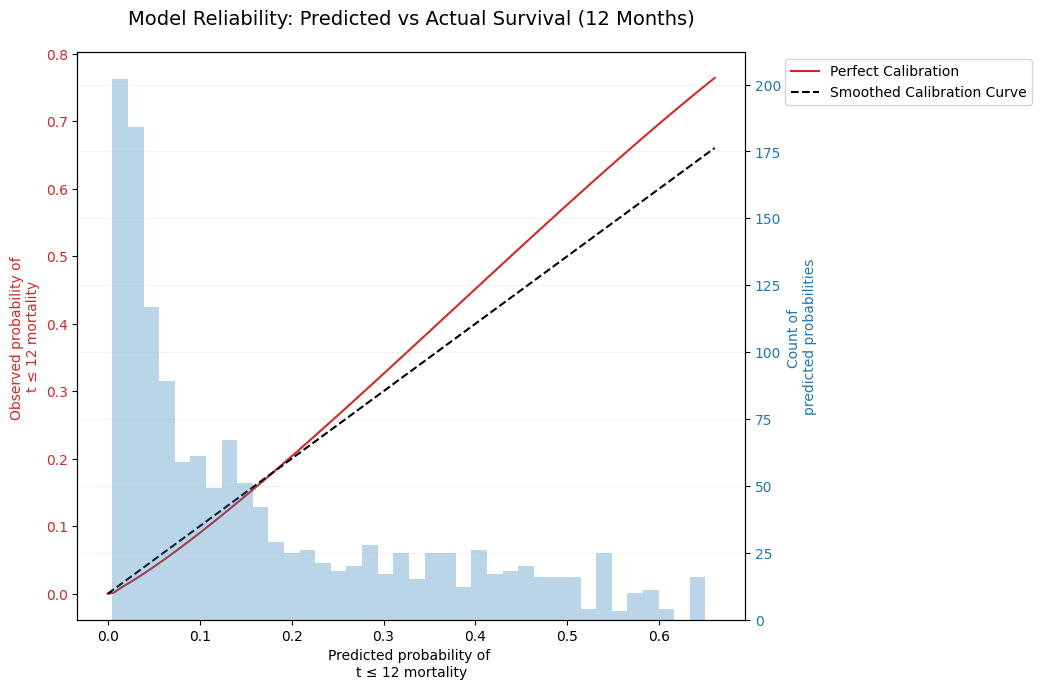

In [172]:
from sklearn.model_selection import train_test_split
from lifelines.utils import k_fold_cross_validation
from lifelines.calibration import survival_probability_calibration

# 1. Fit the model on Train set
cph = CoxPHFitter(penalizer=0.1).fit(train_df, 'tenure', 'Churn')

# 2. Fix CV Score: Specify 'concordance_index' to avoid negative numbers
cv_scores = k_fold_cross_validation(cph, train_df, 'tenure', 'Churn', k=5, scoring_method="concordance_index")
print(f"Training C-Index: {cph.concordance_index_:.3f}")
print(f"Cross-Validation C-Index (Mean): {np.mean(cv_scores):.3f}")
print(f"Test Set C-Index: {cph.score(test_df, scoring_method='concordance_index'):.3f}")

# Move the legend outside to prevent overlapping
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig, ax = plt.subplots(figsize=(10, 7))
_ = survival_probability_calibration(cph, test_df, t0=12, ax=ax)
ax.set_title("Model Reliability: Predicted vs Actual Survival (12 Months)", fontsize=14, pad=20)
ax.legend(['Perfect Calibration','Smoothed Calibration Curve'],loc='upper left',bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.15)
plt.subplots_adjust(right=0.75)
plt.show()

# **Retention Insights & Business Value**

To address your Value Statement,we need to translate the math into business strategy.
The Forest Plot is the best way to show which factors are "Customer Killers."

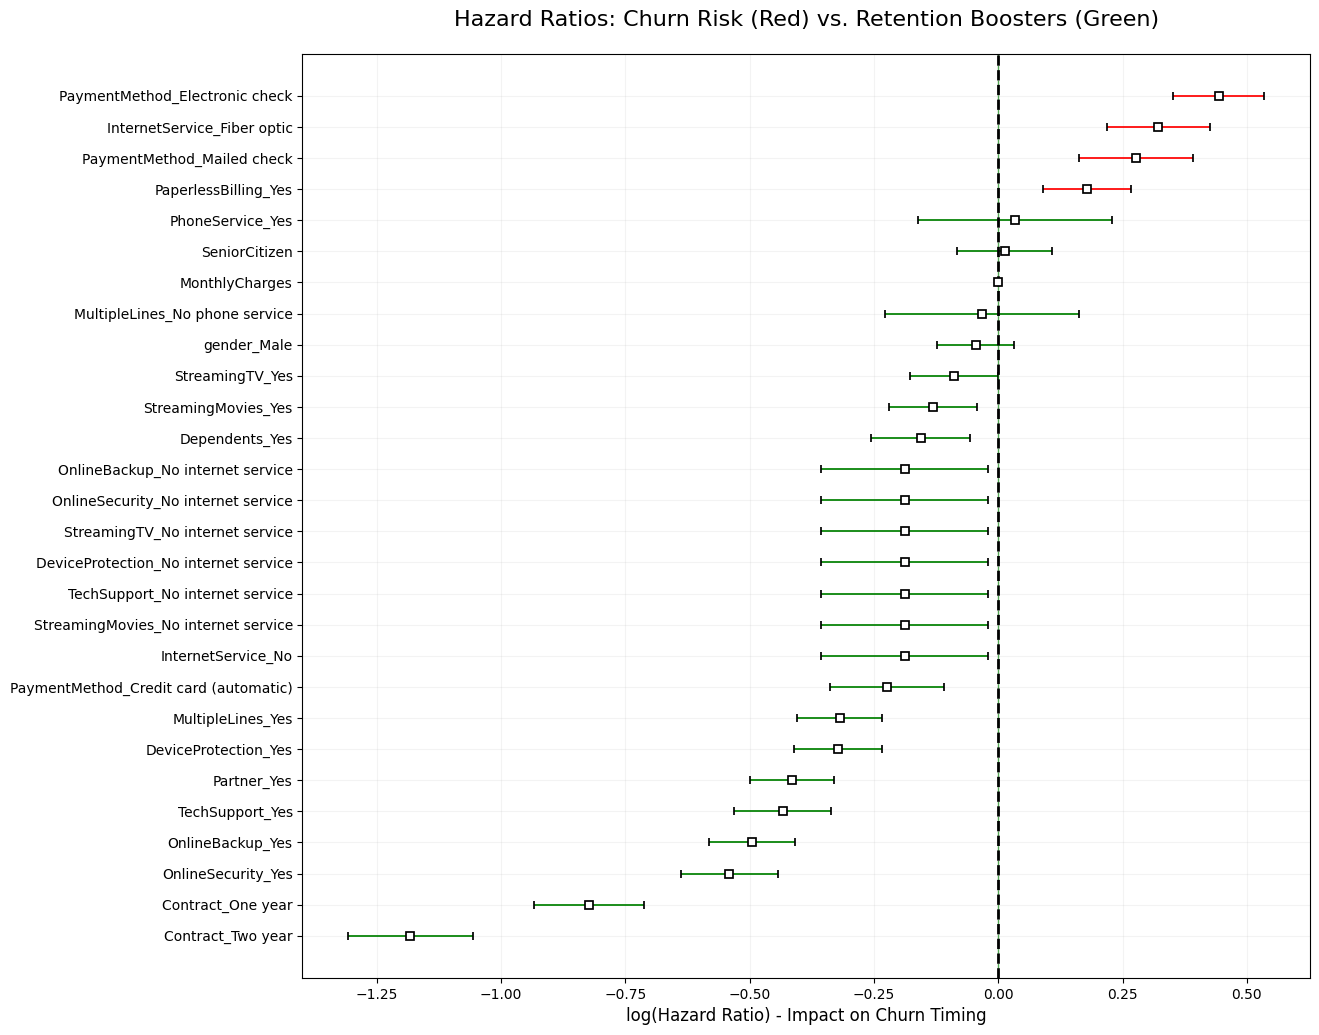

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -14339.18
         time fit was run = 2026-01-05 17:26:03 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                          0.01      1.01      0.05           -0.08            0.11                0.92                1.11
MonthlyCharges                        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
gender_Male                           -0.05      0.96      0.04           -0.12            0.03                0.88                1.03
Partner_Yes                           -0.41      0.66      0.04           -0.50           -0.33                0.61                0.72
Dependents_Yes                        -0.16      0.86      0.05           -0.26           -0.06                0.77                0.95
PhoneService_Yes                       0.03      1.03      0.10           -0.16            0.23                0.85                1.26
MultipleLines_No phone service        -0.03      0.97      0.10           -0.23            0.16                0.80                1.18
MultipleLines_Yes                     -0.32      0.73      0.04           -0.40           -0.23                0.67                0.79
InternetService_Fiber optic            0.32      1.38      0.05            0.22            0.43                1.24                1.53
InternetService_No                    -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
OnlineSecurity_No internet service    -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
OnlineSecurity_Yes                    -0.54      0.58      0.05           -0.64           -0.44                0.53                0.64
OnlineBackup_No internet service      -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
OnlineBackup_Yes                      -0.50      0.61      0.04           -0.58           -0.41                0.56                0.66
DeviceProtection_No internet service  -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
DeviceProtection_Yes                  -0.32      0.72      0.04           -0.41           -0.23                0.66                0.79
TechSupport_No internet service       -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
TechSupport_Yes                       -0.43      0.65      0.05           -0.53           -0.34                0.59                0.71
StreamingTV_No internet service       -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
StreamingTV_Yes                       -0.09      0.92      0.05           -0.18           -0.00                0.84                1.00
StreamingMovies_No internet service   -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98
StreamingMovies_Yes                   -0.13      0.88      0.05           -0.22           -0.04                0.80                0.96
Contract_One year                     -0.82      0.44      0.06           -0.93           -0.71                0.39                0.49
Contract_Two year                     -1.18      0.31      0.06           -1.31           -1.06                0.27                0.35
PaperlessBilling_Yes               

In [167]:
# 1. Fit the final model
cph = CoxPHFitter(penalizer=0.1).fit(df_final, 'tenure', 'Churn')

# 2. Setup the visualization
plt.figure(figsize=(13, 12))
ax = cph.plot()

# 3. ADVANCED COLORING: This targets markers directly
# lifelines uses a 'PathCollection' for the dots (markers)
from matplotlib.collections import LineCollection, PathCollection

for artist in ax.get_children():
    # If it's the center markers (dots)
    if isinstance(artist, PathCollection):
        offsets = artist.get_offsets()
        # Create a color list: red if x > 0, green if x < 0
        new_colors = ['red' if x > 0 else 'green' for x, y in offsets]
        artist.set_facecolors(new_colors)
        artist.set_edgecolors('white') # Make them pop
        artist.set_sizes([100]) # Make them larger and professional

    # If it's the confidence interval lines (whiskers)
    if isinstance(artist, LineCollection):
        # We can color these to match the markers
        segments = artist.get_segments()
        new_line_colors = ['red' if seg[0][0] > 0 else 'green' for seg in segments]
        artist.set_colors(new_line_colors)

# 4. Professional Polish
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.title("Hazard Ratios: Churn Risk (Red) vs. Retention Boosters (Green)", fontsize=16, pad=20)
plt.xlabel("log(Hazard Ratio) - Impact on Churn Timing", fontsize=12)
plt.grid(True, alpha=0.15)
plt.show()

# 5. Export summary for your report
cph.print_summary()

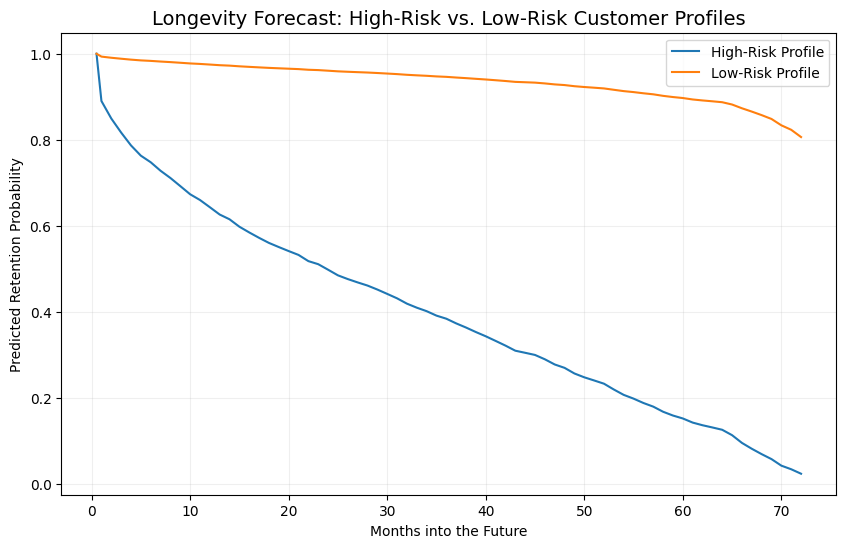

In [168]:
# --- STEP 9.1: INDIVIDUAL PREDICTIONS ---
# Select a 'High Risk' persona and a 'Low Risk' persona from your data
# Example: Row 5 (typically high risk) and Row 11 (typically low risk)
high_risk_cust = df_final.iloc[[5]]
low_risk_cust = df_final.iloc[[11]]

# Forecast their survival probabilities over time
predictions = cph.predict_survival_function(pd.concat([high_risk_cust, low_risk_cust]))

plt.figure(figsize=(10, 6))
plt.plot(predictions)
plt.title("Longevity Forecast: High-Risk vs. Low-Risk Customer Profiles", fontsize=14)
plt.xlabel("Months into the Future")
plt.ylabel("Predicted Retention Probability")
plt.legend(["High-Risk Profile", "Low-Risk Profile"])
plt.grid(True, alpha=0.2)
plt.show()

In [169]:
# Save the plot as a high-resolution image for your report
plt.savefig('Churn_Survival_Forest_Plot.png', dpi=300, bbox_inches='tight')

# Export the statistical summary to a CSV file
cph.summary.to_csv('cox_model_summary.csv')

print("Final files 'Churn_Survival_Forest_Plot.png' and 'cox_model_summary.csv' have been saved to your Colab folder.")

Final files 'Churn_Survival_Forest_Plot.png' and 'cox_model_summary.csv' have been saved to your Colab folder.


<Figure size 640x480 with 0 Axes>

In [171]:
import pickle
# Save the model using the pickle library
with open("telco_churn_cox_model.pkl", "wb") as f:
    pickle.dump(cph, f)

print("Model exported as 'telco_churn_cox_model.pkl' using Pickle.")
print("This file can be loaded into any Python environment to predict churn.")

Model exported as 'telco_churn_cox_model.pkl' using Pickle.
This file can be loaded into any Python environment to predict churn.



# **Project Conclusion:**

- **Key Risk:** Electronic checks and Fiber Optic service are the top "Hazard Multipliers" (Red).

- **Key Strength:** Long-term contracts and Online Security are the top "Retention Anchors" (Green).

- **Strategy:** Shifting customers from high-risk payment/contract types to long-term automated plans will mathematically extend customer tenure and increase lifetime value.